### Подключение библиотек

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency, levene

import requests
from urllib.parse import urlencode

### Загрузка данных

In [ ]:
# Функция для загрузки файлов с Яндекс.Диска через API

def download_file_from_yandex(public_key, save_as, sep):

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode({'public_key': public_key})
    
    try:
        # Получаем загрузочную ссылку
        response = requests.get(final_url)
        response.raise_for_status()
        
        download_url = response.json().get('href')
        if not download_url:
            raise ValueError("Не удалось получить ссылку для скачивания")
        
        # Загружаем файл
        download_response = requests.get(download_url)
        download_response.raise_for_status()
        
        # Сохраняем файл локально
        with open(save_as, 'wb') as f:
            f.write(download_response.content)
        
        # Читаем файл и сохраняем как датафрейм
        try:
            df = pd.read_csv(save_as, sep=sep, encoding='cp1251')
            print(f'Файл успешно загружен и прочитан: {save_as}')
            return df
        except Exception as e:
            raise ValueError(f"Ошибка при чтении файла: {str(e)}")
            
    except requests.exceptions.RequestException as e:
        print(f'Ошибка при загрузке файла: {str(e)}')
        return None
    except Exception as e:
        print(f'Ошибка: {str(e)}')
        return None

In [ ]:
# Загрузка файлов для проекта с Яндекс.Диска

groups = download_file_from_yandex('https://disk.yandex.ru/d/UhyYx41rTt3clQ', 'groups.csv', ';')
active_studs = download_file_from_yandex('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', 'active_studs.csv', ' ')
checks = download_file_from_yandex('https://disk.yandex.ru/d/pH1q-VqcxXjsVA', 'checks.csv', ';')

Файл успешно загружен и прочитан: groups.csv
Файл успешно загружен и прочитан: active_studs.csv
Файл успешно загружен и прочитан: checks.csv


### Исследование данных

### groups

In [ ]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [ ]:
groups.tail()

,id,grp
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B
74483,5694419,B


In [ ]:
groups.shape

(74484, 2)

In [ ]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
groups.nunique()

id     74484
grp        2
dtype: int64

In [ ]:
groups.isnull().sum()

id     0
grp    0
dtype: int64

In [ ]:
groups.query('grp == "A"').id.count()

14671

In [ ]:
groups.query('grp == "B"').id.count()

59813

В датафрейме **groups** 74484 значений, пропусков нет, дублей в id нет. Типы данных корректны.

В контрольной группе (А) 14671 пользователей, в целевой группе (В) 59813 пользователей, что в 4 раза больше контрольной группы.

### active_studs

In [ ]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [ ]:
active_studs.tail()

,student_id
8336,1794344
8337,296883
8338,3598448
8339,3610547
8340,205705


In [ ]:
active_studs.shape

(8341, 1)

In [ ]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [ ]:
active_studs.nunique()

student_id    8341
dtype: int64

In [ ]:
active_studs.isnull().sum()

student_id    0
dtype: int64

В датафрейме **active_studs** 8341 значение, пропусков нет, дублей в id нет. Тип данных корректен.

### checks

In [ ]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [ ]:
checks.tail()

,student_id,rev
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0
540,5740903,1900.0


In [ ]:
checks.shape

(541, 2)

In [ ]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [ ]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [ ]:
checks.isnull().sum()

student_id    0
rev           0
dtype: int64

В датафрейме **checks** 541 значение, пропусков нет, дублей в id нет. Тип данных корректен.

### Объединение датафреймов

In [ ]:
# Приводим колонки с id в датасетах к единому названию
checks = checks.rename(columns={"student_id": "id"})
active_studs = active_studs.rename(columns={"student_id": "id"})

In [ ]:
# Создаем новый датасет с группой пользователей
general_group = groups.copy(deep=True)

In [ ]:
# Добавляем информацию о пользователях, которые зашли на платформу в дни проведения эксперимента
general_group['active'] = general_group['id'].isin(active_studs['id'])

In [ ]:
# Присоединяем данные об оплате
general_group = general_group.merge(checks, how='left', on='id')
general_group['rev'] = general_group['rev'].fillna(0)
general_group.head()

,id,grp,active,rev
0,1489,B,False,0.0
1,1627,A,True,990.0
2,1768,B,False,0.0
3,1783,B,False,0.0
4,1794,A,False,0.0


In [ ]:
# Исследуем объединенный датасет
general_group.shape

(74484, 4)

In [ ]:
general_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74484 entries, 0 to 74483
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      74484 non-null  int64  
 1   grp     74484 non-null  object 
 2   active  74484 non-null  bool   
 3   rev     74484 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
general_group.nunique()

id        74484
grp           2
active        2
rev          40
dtype: int64

In [ ]:
general_group.isnull().sum()

id        0
grp       0
active    0
rev       0
dtype: int64

В датафрейме **general_group** 74484 значений, пропусков нет, дублей в id нет. Типы данных корректны.

In [ ]:
# Посчитаем пользователей по разным критериям и соберем данные в таблицу

users = pd.DataFrame({
    'total_users': general_group.groupby('grp').id.count(),
    'active_users': general_group.query('active == True').groupby('grp').id.count(),
    'paying_users': general_group.query('rev > 0').groupby('grp').id.count(),
    'active_paying_users': general_group.query('active == True & rev > 0').groupby('grp').id.count(),
}).reset_index()

users

,grp,total_users,active_users,paying_users,active_paying_users
0,A,14671,1535,107,78
1,B,59813,6793,433,313


В контрольной группе (А) 1535 активных пользователей, 107 платящих пользователей и 78 активных платящих пользователей.

В целевой группе (В) 6793 активных пользователя, 433 платящих пользователя и 313 активных платящих пользователей.

Для дальнейшего расчёта метрик мы будем использовать только **активных пользователей**, так как нас интересует работа механики оплаты на тех, кто заходил на сайт в день эксперимента и попробовал эту механику на себе.

### Подсчет метрик

Для оценки эффективности новой механики оплаты, я выбрала несколько метрик:

1. **CR** - конверсия активного пользователя в платящего. Показывает, насколько эффективно новая механика оплаты стимулирует пользователей к покупке. Это ключевая метрика, по которой можно смотреть, стоит ли внедрять нововведения по оплате.
2. **ARPPU** - средний доход от активного платящего пользователя. Эта метрика помогает понять, увеличивает ли новая механика средний чек у пользователей.
3. **ARPAU** - средний доход от активного пользователя. Показывает общий эффект от механики, учитывая как конверсию, так и средний чек. 

In [ ]:
# Запишем в переменную активных пользователей
active_users = general_group.query('active == True').groupby('grp')

In [ ]:
# Запишем в переменную активных платящих пользователей
active_paying_users = general_group.query('active == True & rev > 0').groupby('grp')

In [ ]:
# Конверсия активных пользоваетелей в платящих
cr = active_paying_users.id.nunique() / active_users.id.nunique() * 100

In [ ]:
# Средний доход от активного платящего пользователя
arppu = active_paying_users.rev.sum() / active_paying_users.id.nunique()

In [ ]:
# Средний доход от активного пользователя
arpau = active_paying_users.rev.sum() / active_users.id.nunique()

### Сводка по метрикам

In [ ]:
# Собираем все метрики в таблицу
metrics = pd.DataFrame({
    'active_users': active_users.id.count(),
    'active_paying_users': active_paying_users.id.count(),
    'conversion': round(cr, 2),
    'ARPPU': round(arppu, 2),
    'ARPAU': round(arpau, 2)
}).reset_index()

metrics

,grp,active_users,active_paying_users,conversion,ARPPU,ARPAU
0,A,1535,78,5.08,933.59,47.44
1,B,6793,313,4.61,1255.83,57.86


1. Ключевая метрика, конверсия в платящего пользователя (**CR**), рассчитанная для активных пользователей, в целевой группе (B) **ниже на 0.47 п.п.**, чем в контрольной группе. 

2. Средний доход от активного платящего пользователя (**ARPPU**) в целевой группе **выше на 34.5%**.

3. Средний доход от активного пользователя (**ARPAU**) в целевой группе **выше на 22.0%**.

Ключевую метрику (CR) новая механика снизила, что является неблагоприятным сигналом, ведь одна из основных целей нововведений - привлечь больше покупателей. 

Рост ARPPU может указывать на то, что новая механика упростила покупку дорогих услуг. Общий доход с активных пользователей (ARPAU) вырос за счёт роста ARPPU, несмотря на снижение конверсии. 

Все эти изменения в метриках могут говорить о том, что новая механика хорошо сработала на тех, кто готов был платить и покупать более дорогие услуги, но оттолкнула часть остальной аудитории. Для оценки результатов необходимо рассчитать статистическую значимость различий.

### Оценка статистической значимости

### 1. CR

Для сравнения конверсий (CR) между группами можно использовать **критерий хи-квадрат**. Он подходит для анализа таблиц сопряженности, где сравниваются наблюдаемые частоты событий. В данном случае - количество платящих и неплатящих пользователей в группах A и B.

- **Нулевая гипотеза (H₀)**: Конверсии в группах равны 

- **Альтернативная гипотеза (H₁)**: Конверсии в группах различаются 

In [ ]:
# Подготовим данные по платежам, разделим пользователей на группы

# Активных платящих
paying_group_a = general_group.query('active == True & rev > 0 & grp == "A"').rev
paying_group_b = general_group.query('active == True & rev > 0 & grp == "B"').rev

# Активных неплатящих
non_paying_group_a = general_group.query('active == True & rev == 0 & grp == "A"').rev
non_paying_group_b = general_group.query('active == True & rev == 0 & grp == "B"').rev

In [ ]:
# Строим таблицу сопряженности
chi_table = [[paying_group_a.count(), non_paying_group_a.count()], 
            [paying_group_b.count(), non_paying_group_b.count()]]

# Проверка хи-квадрат
chi2_stat, p_value, dof, expected = chi2_contingency(chi_table, correction=False)

print(f"Результаты теста хи-квадрат:")
print(f"χ² = {round(chi2_stat, 3)}, p-value = {round(p_value, 3)}")

Результаты теста хи-квадрат:
χ² = 0.628, p-value = 0.428


Разница в конверсиях статистически незначима (p-value > 0.05), значит мы не отклоняем нулевую гипотезу и считаем, что **конверсии в группах равны**. Наблюдаемые различия могут быть связаны со случайными колебаниями или дисбалансом в размерах групп. Либо реальное влияние механики на CR крайне мало.

### 2. ARPPU

Для выбора статистического теста необходимо оценить распределение данных и равенство дисперсий. В данном случае мы берём данные по **активным платящим пользователям**, разделенные по группам.

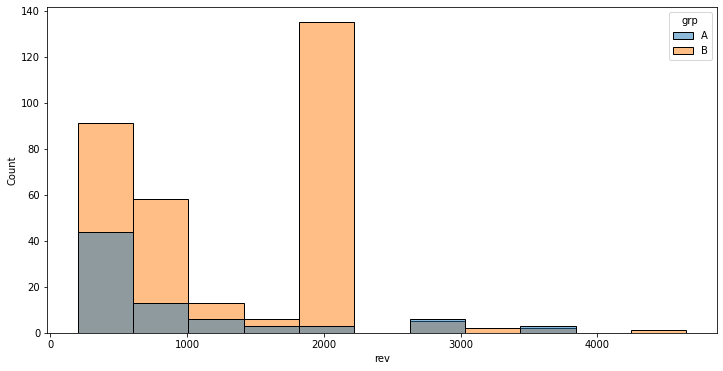

In [ ]:
# Построим гистограмму распределения платежей от активных платящих пользователей по группам
plt.figure(figsize=(12, 6))
sns.histplot(x='rev', data=general_group.query('active == True & rev > 0'), hue='grp')

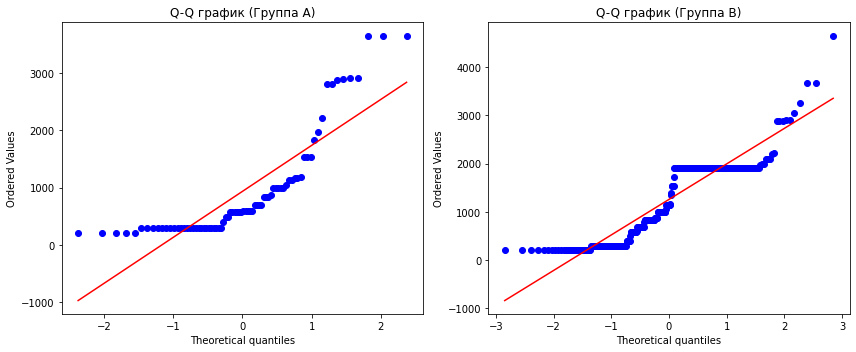

In [ ]:
# Построим Q-Q график платежей от активных пользователей по группам
plt.figure(figsize=(12, 5))

# Q-Q график для группы A
plt.subplot(1, 2, 1)
stats.probplot(paying_group_a, dist="norm", plot=plt)
plt.title('Q-Q график (Группа A)')

# Q-Q график для группы B
plt.subplot(1, 2, 2)
stats.probplot(paying_group_b, dist="norm", plot=plt)
plt.title('Q-Q график (Группа B)')

plt.tight_layout()
plt.show()

Данные по платежам от активных платящих пользователей по группам распределены ненормально, есть правая асимметрия и выбросы по большим платежам.

-------------

Дополнительно необходимо оценить равенство дисперсий. Для этого применим **тест Левена**.

- **Нулевая гипотеза (H₀)**: Дисперсии в группах равны

- **Альтернативная гипотеза (H₁)**: Дисперсии в группах различаются

In [ ]:
# Применяем тест Левена для оценки дисперсий (активные платящие пользователи)
levene(paying_group_a, paying_group_b)

LeveneResult(statistic=3.0558643506726035, pvalue=0.08123509393501775)

Разница в дисперсиях статистически незначима (p-value > 0.05), значит мы не отклоняем нулевую гипотезу и считаем, что **дисперсии в группах равны**. 

------

При равенстве дисперсий можно применить **t-тест по Стьюденту**, несмотря на ненормальность распределения.

- **Нулевая гипотеза (H₀)**: Средний доход на платящего пользователя в группах A и B не различается

- **Альтернативная гипотеза (H₁)**: Средний доход на платящего пользователя в группах A и B различается

In [ ]:
# t-тест для ARPPU
t_stat, p_value = stats.ttest_ind(paying_group_a, paying_group_b, equal_var=True)

print(f't-statistic = {round(t_stat, 3)}, p-value = {round(p_value, 3)}')

t-statistic = -3.111, p-value = 0.002


Различия в ARPPU статистически значимы (p-value < 0.05), значит мы отклоняем нулевую гипотезу и принимаем альтернативную, что **ARPPU в группах различается**. Это может быть важным для бизнеса, так как увеличение ARPPU может привести к значительному увеличению доходов.

### 3. ARPAU

Пл аналогии с ARPPU, необходимо предварительно оценить распределение данных и равенство дисперсий. В данном случае мы берём данные по **всем активным пользователям**, разделенные по группам.

In [ ]:
# Подготовим данные по платежам, разделим активных пользователей на группы
active_group_a = general_group.query('active == True & grp == "A"').rev
active_group_b = general_group.query('active == True & grp == "B"').rev

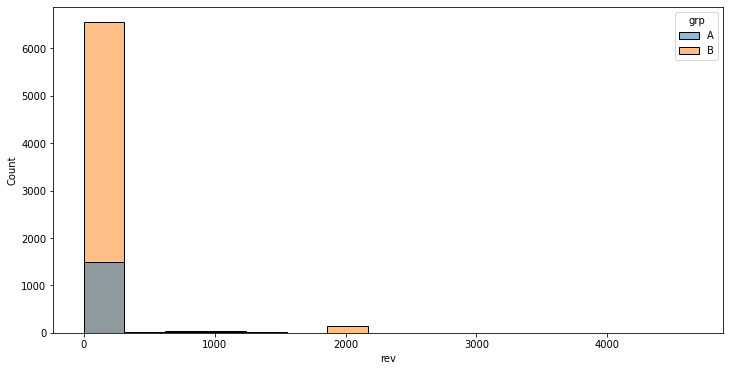

In [ ]:
# Построим гистограмму распределения платежей от активных пользователей по группам
plt.figure(figsize=(12, 6))
sns.histplot(x='rev', data=general_group.query('active == True'), hue='grp')

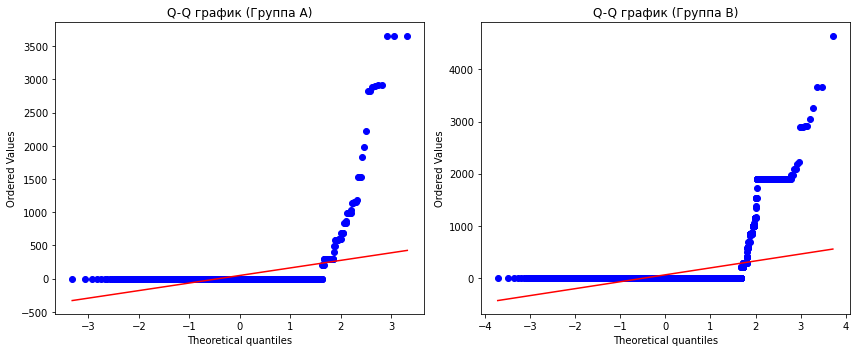

In [ ]:
# Построим Q-Q график платежей от активных пользователей по группам
plt.figure(figsize=(12, 5))

# Q-Q график для группы A
plt.subplot(1, 2, 1)
stats.probplot(active_group_a, dist="norm", plot=plt)
plt.title('Q-Q график (Группа A)')

# Q-Q график для группы B
plt.subplot(1, 2, 2)
stats.probplot(active_group_b, dist="norm", plot=plt)
plt.title('Q-Q график (Группа B)')

plt.tight_layout()
plt.show()

Данные по платежам от активных пользователей по группам распределены ненормально, есть правая асимметрия и выбросы по большим платежам.

--------

Дополнительно необходимо оценить равенство дисперсий. Для этого применим **тест Левена**.

- **Нулевая гипотеза (H₀)**: Дисперсии в группах равны

- **Альтернативная гипотеза (H₁)**: Дисперсии в группах различаются

In [ ]:
# Применяем тест Левена для оценки дисперсий (активные пользователи)
levene(active_group_a, active_group_b)

LeveneResult(statistic=1.4233907944574833, pvalue=0.2328800964343609)

Разница в дисперсиях статистически незначима (p-value > 0.05), значит мы принимаем альтернативную гипотезу и считаем, что **дисперсии в группах равны**.

----------

При равенстве дисперсий можно применить **t-тест по Стьюденту**, несмотря на ненормальность распределения.

- **Нулевая гипотеза (H₀)**: Средний доход на активного пользователя в группах A и B не различается

- **Альтернативная гипотеза (H₁)**: Средний доход на активного пользователя в группах A и B различается

In [ ]:
# t-тест для ARPAU
t_stat, p_value = stats.ttest_ind(active_group_a, active_group_b, equal_var=True)

print(f't-statistic = {round(t_stat, 3)}, p-value = {round(p_value, 3)}')

t-statistic = -1.193, p-value = 0.233


Различия в ARPAU статистически незначимы (p-value > 0.05), значит мы принимаем нулевую гипотезу и считаем, что **ARPAU в группах не различается**. Наблюдаемая разница может быть обусловлена случайными колебаниями данных.

### Выводы и рекомендации

**Основные результаты A/B-теста**

1. Наблюдается снижение конверсии активных пользователей в платящих в целевой группе на 0.47%, но разница статистически незначима. Наблюдаемые различия могут быть связаны со случайными колебаниями, дисбалансом в размерах групп или незначительным реальным влиянием механики на CR. 

2. Средний доход на активного платящего пользователя (ARPPU) в целевой группе вырос на 34.5%, и разница статистически значима. Это указывает, что новая механика упростила покупку дорогих услуг, либо увеличила средний чек существующих платящих пользователей.

3. Средний доход на активного пользователя (ARPAU) показал рост на 22.0% в целевой группе, но разница незначима. Это означает, что рост ARPPU не компенсировал снижение конверсии.

**Позитивные эффекты новой механики**

- улучшила опыт для покупателей дорогих услуг (рост ARPPU)

- возможно, упростила процесс совершения дорогих покупок (например, премиум-подписки)

**Негативные эффекты**

- Механика усложнила оплату для остальных пользователей (снижение CR)

- Могла оттолкнуть тех, кто не готов к большим тратам

**Возможные внешние факторы**

- Сезонность, маркетинговые акции, изменения в ассортименте

- Дисбаланс в демографии пользователей (например, в группе B больше пользователей с высоким доходом)

**Рекомендации для дальнейших действий**

1. Доработка механики:
   
   - Для "обычных" пользователей: 

       - Упростите процесс оплаты (например, убрать шаги, которые могли отпугнуть)

       - Протестируйте упрощённую версию механики только для новых пользователей

   - Для "премиум" пользователей:

       - Сохраните текущие изменения, так как они хорошо работают для этой аудитории

       - Добавьте персонализированные предложения (например, бонусы за крупные покупки)
       

2. Дополнительный анализ

    - Сегментация пользователей 

        - Новые vs старые пользователи

        - Разные демографические группы (возраст, доход, поведение)

    - Проверка внешних факторов:

        - Исключите влияние маркетинга

        - Сравните данные с аналогичным периодом в прошлом (сезонность)

    - Долгосрочные метрики:

        - Оцените 30-дневный ARPAU и Retention Rate

        - Проверьте, не увеличился ли отток пользователей из-за новой механики

**Итог**

Не стоит запускать новую механику в текущем виде, так как ключевая метрика (CR) снизилась, хоть и незначимо. При этом рост ARPPU не компенсировал снижения конверсии. Оптимальным решением будет тестирование гибридного варианта механики для разных пользователей.